In [1]:
from contextual_bandit import ContextualBandit
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from Fusion_Model import FusionModel, LSTM
import json
import matplotlib.pyplot as plt
from CenterLoss import CenterLoss
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def get_dataloaders(pathX, pathy, batch_size = None):
    X_df = pd.read_csv(pathX, index_col=0)
    X_df['employee embedding'] = X_df['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
    X_df['company embedding'] = X_df['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
    employee = torch.tensor(np.vstack(X_df['employee embedding'].values), dtype=torch.float64)
    company = torch.tensor(np.vstack(X_df['company embedding'].values), dtype=torch.float64)
    LSTM_X = torch.zeros(employee.shape[0], 2, employee.shape[1])
    LSTM_X[:, 0, :] = employee
    LSTM_X[:, 1, :] = company
    y = torch.load(pathy)
    dataset = TensorDataset(LSTM_X,y.long())
    if batch_size is None:
        dataloader = DataLoader(dataset, batch_size=LSTM_X.shape[0], shuffle=True)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [3]:
test_dataloader = get_dataloaders('data/X_test.csv', 'data/y_test.pt')

In [4]:
X_train_df, y_train = pd.read_csv('data/X_train.csv', index_col = 0), pd.read_csv('data/y_train.csv', index_col=0)
X_train_df['employee embedding'] = X_train_df['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_train_df['company embedding'] = X_train_df['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_train_df.iloc[:, 1:].values.shape
employee_embedding_tensor = torch.tensor(np.vstack(X_train_df['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor = torch.tensor(np.vstack(X_train_df['company embedding'].values), dtype=torch.float64)
LSTM_X = torch.zeros(employee_embedding_tensor.shape[0], 2, 32)
LSTM_X[:, 0, :] = employee_embedding_tensor
LSTM_X[:, 1, :] = company_embedding_tensor
y_train = torch.load('data/y_train.pt')

In [5]:
cutoff = int(LSTM_X.shape[0]*0.7)
LSTM_X_train, y_train1 = LSTM_X[:cutoff, :, :], y_train[:cutoff]
LSTM_X_val, y_val = LSTM_X[cutoff:, :, :], y_train[cutoff:]
y_train = y_train1

In [205]:
data1 = LSTM_X
y1 = y_train == 0
pd.Series(y1).value_counts() / len(y1)

False    0.691764
True     0.308236
Name: count, dtype: float64

In [ ]:
model1 = LSTM()

In [187]:
pd.Series(y_train).value_counts()

1.0    12840
0.0     5945
2.0      878
3.0      828
Name: count, dtype: int64

In [172]:
def train(epochs, lr, train_data, val_data, model, criterion):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losses = []
    # f1_scores = []
    train_val, val_y = next(iter(val_data)) # assumes only 1 batch in training data
    # prev_F1 = 0
    model.train()
    for epoch in tqdm(range(epochs)):
        running_loss = []
        # running_f1 = []
        for batch in train_data:
            X,y = batch
            emb = model(X).squeeze(1)
            emb = torch.clamp(emb, 0, 4)
            # preds = torch.argmax(emb, dim = 1)
            # preds = preds.float()
            # f1_score_epoch = f1_score(y, preds, average='macro')
            optimizer.zero_grad()
            loss = criterion(emb, y.float())
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
            # running_f1.append(f1_score_epoch)
        losses.append(np.mean(running_loss))
        # f1_scores.append(np.mean(running_f1))
        if epoch % 10 == 0:
            val_probs = model(train_val)
            # val_preds = torch.argmax(val_probs, dim = 1)
            # # val_f1 = f1_score(val_y, val_preds, average = 'macro')
            # if val_f1 < prev_F1:
            #     print('early stopping')
            #     model.eval()
            #     return losses, f1_scores
            # else:
            # print('Val F1 score: ', val_f1)
            print('Train loss: ', losses[-1])
            # print('F1 score: ', f1_scores[-1])
            # prev_F1 = val_f1
    model.eval()
    return losses

In [113]:
weights = 1/np.array([0.3, 0.6, 0.05, 0.05])
weights /= sum(np.sqrt(weights**2))

In [115]:
sum(weights)

1.0

In [120]:
weights

tensor([0.0741, 0.0370, 0.4444, 0.4444])

In [195]:
from Fusion_Model import LSTM

lstm_only = LSTM(1, 32, 128, 3)
weights = torch.tensor([0.01, 0.01, 0.49, 0.49]).float()
# criterion = nn.CrossEntropyLoss(weights)
criterion = nn.MSELoss()
losses = train(100, 1e-3, train_dataloader, val_dataloader, lstm_only, criterion)

  1%|          | 1/100 [00:02<04:43,  2.87s/it]

Train loss:  0.4948031265543114


 11%|█         | 11/100 [00:24<03:11,  2.15s/it]

Train loss:  0.4028759668147342


 21%|██        | 21/100 [00:47<03:01,  2.30s/it]

Train loss:  0.3559450249864448


 31%|███       | 31/100 [01:09<02:33,  2.23s/it]

Train loss:  0.3117160437084873


 41%|████      | 41/100 [01:34<02:22,  2.42s/it]

Train loss:  0.2686510124006627


 51%|█████     | 51/100 [01:57<01:55,  2.35s/it]

Train loss:  0.2161019740175016


 61%|██████    | 61/100 [02:20<01:29,  2.31s/it]

Train loss:  0.16853378680737122


 71%|███████   | 71/100 [02:41<01:01,  2.13s/it]

Train loss:  0.12639628461799265


 81%|████████  | 81/100 [03:04<00:40,  2.12s/it]

Train loss:  0.08827390591180102


 82%|████████▏ | 82/100 [03:08<00:41,  2.30s/it]


KeyboardInterrupt: 

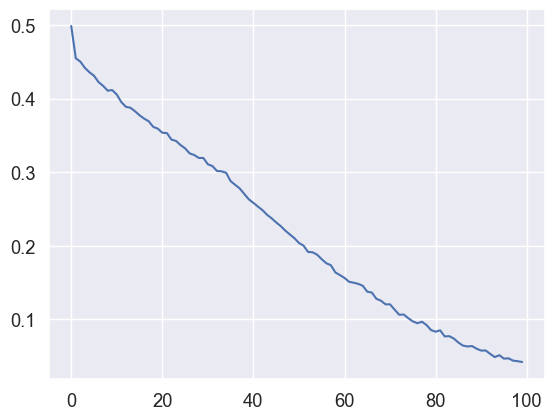

In [ ]:
plt.plot(losses)

In [ ]:
for X,y in dataloader:
    lstm_only()

In [143]:
LSTM_X_test, LSTM_y_test = next(iter(test_dataloader))
probs = lstm_only(LSTM_X_test)
preds = torch.argmax(probs, dim=1)
f1_score(LSTM_y_test, preds, average = 'macro')

0.17754621406804985

In [130]:
np.sum(conf_matrix, axis = 1)

array([1882, 1812, 1818, 1815])

In [136]:
conf_matrix.astype(float)

array([[ 436., 1312.,   79.,   55.],
       [ 390., 1291.,   76.,   55.],
       [ 391., 1281.,   78.,   68.],
       [ 432., 1242.,   83.,   58.]])

In [146]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(LSTM_y_test, preds)

conf_matrix = conf_matrix.astype(float) 
conf_matrix /= np.sum(conf_matrix, axis = 1)
conf_matrix.diagonal()

array([0.22316684, 0.73565121, 0.02420242, 0.02809917])

([<matplotlib.axis.YTick at 0x1a0dc9cd0>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')])

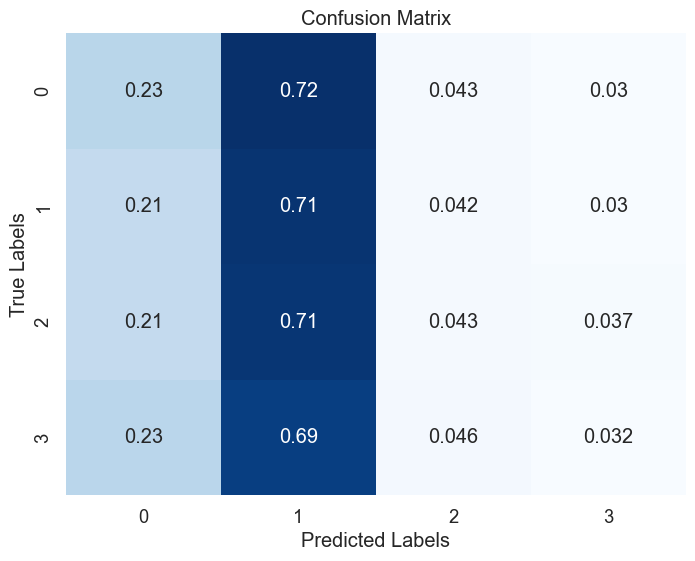

In [141]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability

# Create heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False)

# Set labels, title, and axis ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(conf_matrix))+0.5, labels=np.arange(len(conf_matrix)))
plt.yticks(ticks=np.arange(len(conf_matrix))+0.5, labels=np.arange(len(conf_matrix)))

In [119]:
pd.Series(y_train).value_counts()

1.0    12840
0.0     5945
2.0      878
3.0      828
Name: count, dtype: int64

In [122]:
losses[-1]

0.01109021907435117

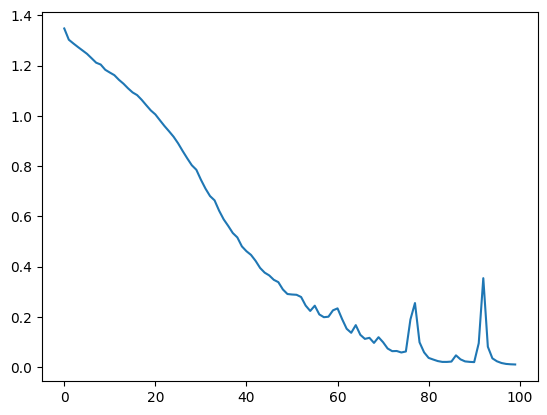

In [121]:
plt.plot(losses)

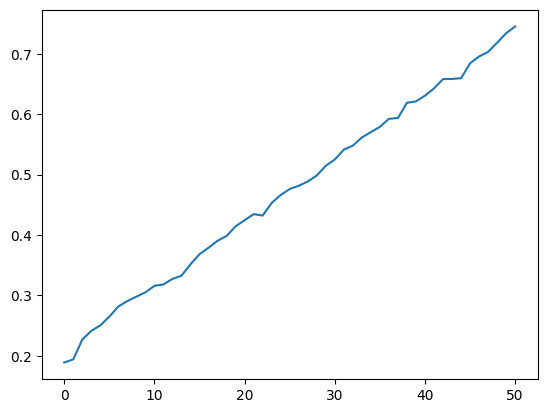

In [88]:
plt.plot(F1_scores)

In [175]:
predictions = []
for batch in val_dataloader:
    X, y = batch
    preds = lstm_only(X)
    preds = torch.round(preds)
    preds = preds.int()
    predictions.append(preds)


In [181]:
y_pred = torch.tensor(np.array(predictions))[0, :, 0]

In [185]:
y_val.shape == y_pred.shape

True

In [186]:
f1_score(y_pred, y_val, average = 'macro')

0.06760809121881456

In [57]:
new_preds = []

for lst in predictions:
    for a in lst:
        new_preds.append(a.item())

In [60]:
len(new_preds), y_train.shape

(29273, (29273, 2))

In [67]:
f1_score(y_train, new_preds, average = 'macro')

0.25057272321093

In [64]:
y_train

tensor([1., 1., 1.,  ..., 1., 1., 1.])